***Название***: Анализ признаковых пространств

Выполнила: Чванкина Дарья

Цель работы: Провести анализ качества признакового пространства с помощью визуализации слоёв нейросети и самого пространства.

Датасет: STL-10

Выбранные сети для анализа: ResNet18, VGG19 и AlexNet

Используемые ссылки:

https://androidkt.com/how-to-visualize-feature-maps-in-convolutional-neural-networks-using-pytorch/

https://medium.com/analytics-vidhya/deep-dream-visualizing-the-features-learnt-by-convolutional-networks-in-pytorch-b7296ae3b7f

http://stevenrush.github.io/understanding-cnn/

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

https://cs.stanford.edu/people/karpathy/cnnembed/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!g1.1
import torchvision.datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, models
import os
import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

## Данные

Загрузим данные. В данных 10 классов. Есть набор для обучения, для теста, а также не помеченные картинки. Данный набор данных используется для частичного обучения. Мы будем пользоваться только данными для теста и для обучения.

In [ ]:
data = torchvision.datasets.STL10(root='./data', download=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
dataset = torchvision.datasets.STL10(root='./data', download=False, transform=ToTensor())

In [ ]:
dataset_size = len(dataset)
classes = dataset.classes
dataset_size, dataset.classes, len(dataset.classes)

(5000,
 ['airplane',
  'bird',
  'car',
  'cat',
  'deer',
  'dog',
  'horse',
  'monkey',
  'ship',
  'truck'],
 10)

Label (numeric): 1
Label (textual): bird


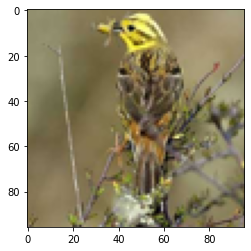

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [ ]:
input_size  = 96*96   # размер изображения
output_size = 10      # 10 классов

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406], 
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])])


train_loader = torch.utils.data.DataLoader(
    datasets.STL10('./data', split ='train', download=True,
                   transform=train_transforms),
    batch_size=4, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    datasets.STL10('./data', split ='test', transform=val_transforms),
    batch_size=4, shuffle=True)

Files already downloaded and verified


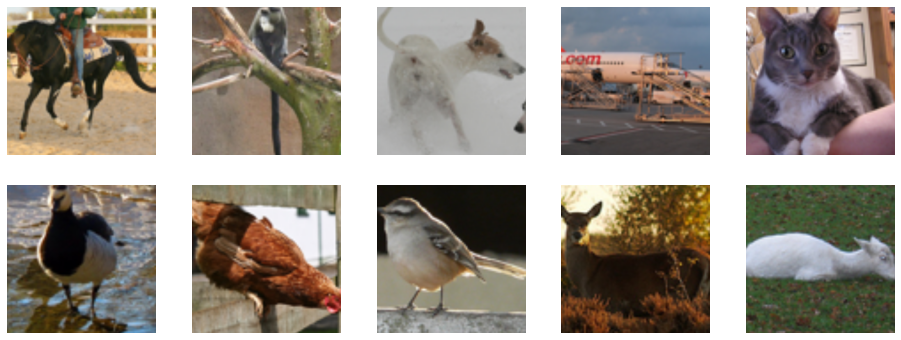

In [ ]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = val_loader.dataset.__getitem__(i)
    image[0] = image[0]*0.229 + 0.485
    image[1] = image[1]*0.224 + 0.456
    image[2] = image[2]*0.225 + 0.406
    plt.imshow(image.permute((1, 2, 0)))
    plt.axis('off');

# TransferLearning

Возьмем уже предобученные модели ResNet18, VGG19 и AlexNet из torchvision.models. В последнем линейном слое каждой сети изменим размер выходных данных на 10, так как всего у нас 10 классов.

## Transfer learning, ResNet18

In [ ]:
resnet18 = models.resnet18(pretrained=True)

print(resnet18.fc)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)
print(resnet18.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth



Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=10, bias=True)


In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#!g1.1
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    resnet18.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [ ]:
#!g1.1
device

device(type='cuda', index=0)

In [ ]:
#!g1.1
num_epochs=25

for epoch in range(num_epochs):

    resnet18.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()

    resnet18.eval() # <3>
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)

    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)
    
    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Train: Loss: 0.2348 Acc: 0.6928 Val: Loss: 0.2078 Acc: 0.7531
Train: Loss: 0.2193 Acc: 0.7246 Val: Loss: 0.1637 Acc: 0.8003
Train: Loss: 0.1702 Acc: 0.7820 Val: Loss: 0.1221 Acc: 0.8499
Train: Loss: 0.1370 Acc: 0.8122 Val: Loss: 0.1016 Acc: 0.8645
Train: Loss: 0.1317 Acc: 0.8236 Val: Loss: 0.0964 Acc: 0.8776
Train: Loss: 0.1323 Acc: 0.8192 Val: Loss: 0.0989 Acc: 0.8726
Train: Loss: 0.1407 Acc: 0.8094 Val: Loss: 0.1272 Acc: 0.8521
Train: Loss: 0.0842 Acc: 0.8838 Val: Loss: 0.0635 Acc: 0.9221
Train: Loss: 0.0861 Acc: 0.8788 Val: Loss: 0.0632 Acc: 0.9193
Train: Loss: 0.0725 Acc: 0.8984 Val: Loss: 0.0543 Acc: 0.9319
Train: Loss: 0.0674 Acc: 0.9068 Val: Loss: 0.0582 Acc: 0.9285
Train: Loss: 0.0705 Acc: 0.9044 Val: Loss: 0.0573 Acc: 0.9249
Train: Loss: 0.0649 Acc: 0.9106 Val: Loss: 0.0513 Acc: 0.9323
Train: Loss: 0.0641 Acc: 0.9134 Val: Loss: 0.0532 Acc: 0.9310
Train: Loss: 0.0616 Acc: 0.9106 Val: Loss: 0.0501 Acc: 0.9354
Train: Loss: 0.0621 Acc: 0.9138 Val: Loss: 0.0509 Acc: 0.9353
Train: L

In [ ]:
#!g1.1
torch.save(resnet18.state_dict(), "./resnet18_dict.pth")

In [ ]:
#!g1.1
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, 10)
resnet18.load_state_dict(torch.load('/content/drive/MyDrive/Модельки Даши/resnet18_dict.pth'))

<All keys matched successfully>

## Transfer learning, VGG19

In [ ]:
#!g1.1
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6]= nn.Linear(4096, 10)


In [ ]:
#!g1.1
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#!g1.1
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = vgg19.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    vgg19.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [ ]:
#!g1.1
num_epochs=25

for epoch in range(num_epochs):

    vgg19.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vgg19(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()

    vgg19.eval() # <3>
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = vgg19(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)

    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = vgg19(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)
    
    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Train: Loss: 0.2041 Acc: 0.7032 Val: Loss: 0.1271 Acc: 0.8215
Train: Loss: 0.1792 Acc: 0.7554 Val: Loss: 0.1038 Acc: 0.8658
Train: Loss: 0.1542 Acc: 0.7818 Val: Loss: 0.0797 Acc: 0.8904
Train: Loss: 0.1664 Acc: 0.7640 Val: Loss: 0.1085 Acc: 0.8498
Train: Loss: 0.1497 Acc: 0.7918 Val: Loss: 0.1060 Acc: 0.8571
Train: Loss: 0.1492 Acc: 0.7938 Val: Loss: 0.0953 Acc: 0.8711
Train: Loss: 0.1300 Acc: 0.8226 Val: Loss: 0.0728 Acc: 0.8979
Train: Loss: 0.0804 Acc: 0.8844 Val: Loss: 0.0479 Acc: 0.9354
Train: Loss: 0.0729 Acc: 0.8962 Val: Loss: 0.0446 Acc: 0.9394
Train: Loss: 0.0680 Acc: 0.9088 Val: Loss: 0.0461 Acc: 0.9399
Train: Loss: 0.0631 Acc: 0.9106 Val: Loss: 0.0445 Acc: 0.9416
Train: Loss: 0.0636 Acc: 0.9074 Val: Loss: 0.0469 Acc: 0.9391
Train: Loss: 0.0541 Acc: 0.9236 Val: Loss: 0.0425 Acc: 0.9451
Train: Loss: 0.0576 Acc: 0.9192 Val: Loss: 0.0429 Acc: 0.9455
Train: Loss: 0.0541 Acc: 0.9230 Val: Loss: 0.0413 Acc: 0.9467
Train: Loss: 0.0547 Acc: 0.9210 Val: Loss: 0.0412 Acc: 0.9474
Train: L

In [ ]:
#!g1.1
torch.save(vgg19.state_dict(), "./vgg19_dict.pth")

In [ ]:
#!g1.1
vgg19 = models.vgg19(pretrained=False)
vgg19.classifier[6]= nn.Linear(4096, 10)
vgg19.load_state_dict(torch.load('/content/drive/MyDrive/Модельки Даши/vgg19_dict.pth'))

<All keys matched successfully>

## Transfer leraning, AlexNet

In [ ]:
#!g1.1
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /tmp/xdg_cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


In [ ]:
#!g1.1
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

In [ ]:
#!g1.1
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

alexnet = alexnet.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    alexnet.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [ ]:
#!g1.1
num_epochs=25

for epoch in range(num_epochs):

    alexnet.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()

    alexnet.eval() # <3>
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)

    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)
    
    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Train: Loss: 0.3391 Acc: 0.5190 Val: Loss: 0.2903 Acc: 0.5974
Train: Loss: 0.2623 Acc: 0.6322 Val: Loss: 0.2083 Acc: 0.7069
Train: Loss: 0.2222 Acc: 0.6830 Val: Loss: 0.1840 Acc: 0.7395
Train: Loss: 0.2286 Acc: 0.6724 Val: Loss: 0.1887 Acc: 0.7300
Train: Loss: 0.2024 Acc: 0.7024 Val: Loss: 0.1751 Acc: 0.7570
Train: Loss: 0.2276 Acc: 0.6880 Val: Loss: 0.1977 Acc: 0.7316
Train: Loss: 0.2093 Acc: 0.7014 Val: Loss: 0.1816 Acc: 0.7448
Train: Loss: 0.1325 Acc: 0.8116 Val: Loss: 0.1192 Acc: 0.8334
Train: Loss: 0.1251 Acc: 0.8258 Val: Loss: 0.1088 Acc: 0.8471
Train: Loss: 0.1161 Acc: 0.8402 Val: Loss: 0.1026 Acc: 0.8586
Train: Loss: 0.1138 Acc: 0.8370 Val: Loss: 0.1064 Acc: 0.8498
Train: Loss: 0.1054 Acc: 0.8504 Val: Loss: 0.0974 Acc: 0.8658
Train: Loss: 0.1068 Acc: 0.8500 Val: Loss: 0.0982 Acc: 0.8595
Train: Loss: 0.1087 Acc: 0.8448 Val: Loss: 0.0993 Acc: 0.8624
Train: Loss: 0.0988 Acc: 0.8620 Val: Loss: 0.0924 Acc: 0.8695
Train: Loss: 0.0977 Acc: 0.8628 Val: Loss: 0.0916 Acc: 0.8718
Train: L

In [ ]:
alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6]= nn.Linear(4096, 10)
alexnet.load_state_dict(torch.load('/content/drive/MyDrive/Модельки Даши/alexnet_dict.pth'))

<All keys matched successfully>

In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Визуализация

## Фильтры первого слоя

Рассмотрим обученные свертки первого слоя каждой модели.

### ResNet18

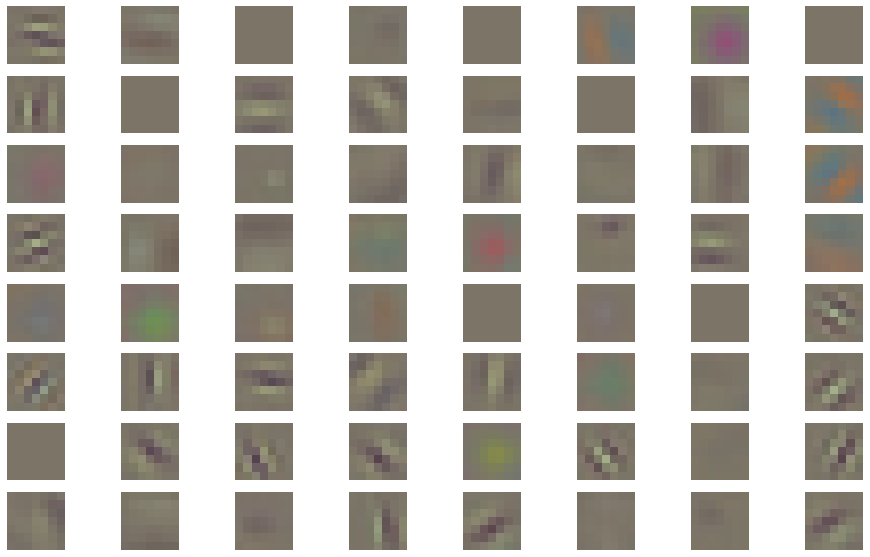

In [ ]:
#!g1.1
plt.figure(figsize=(16, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    image = list(resnet18.named_parameters())[0][1][i].detach().to('cpu').numpy() #[0,:,:]
    image[0] = image[0]*0.229 + 0.485
    image[1] = image[1]*0.224 + 0.456
    image[2] = image[2]*0.225 + 0.406
    plt.imshow(image.transpose((1, 2, 0)) )
    plt.axis('off')

### VGG19

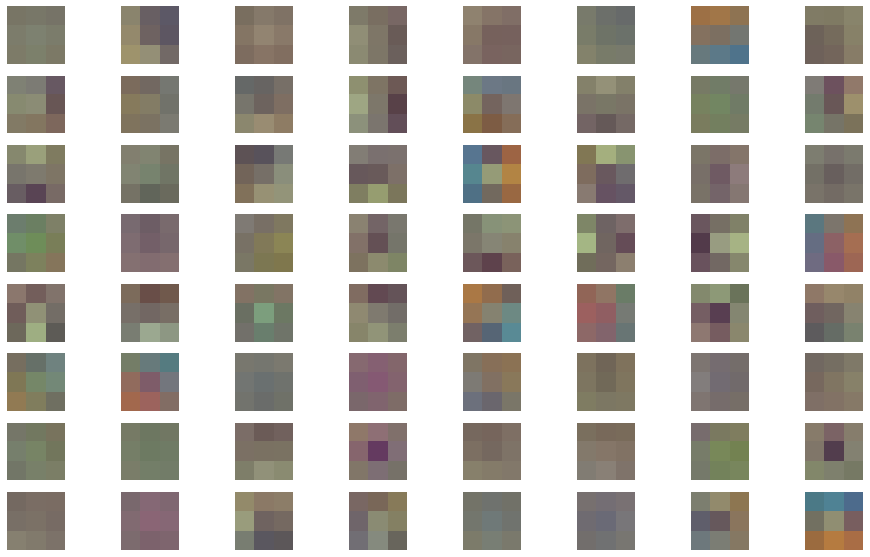

In [ ]:
#!g1.1
plt.figure(figsize=(16, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    image = list(vgg19.named_parameters())[0][1][i].detach().to('cpu').numpy() #[0,:,:]
    image[0] = image[0]*0.229 + 0.485
    image[1] = image[1]*0.224 + 0.456
    image[2] = image[2]*0.225 + 0.406
    plt.imshow(image.transpose((1, 2, 0)) )
    plt.axis('off')

### AlexNet

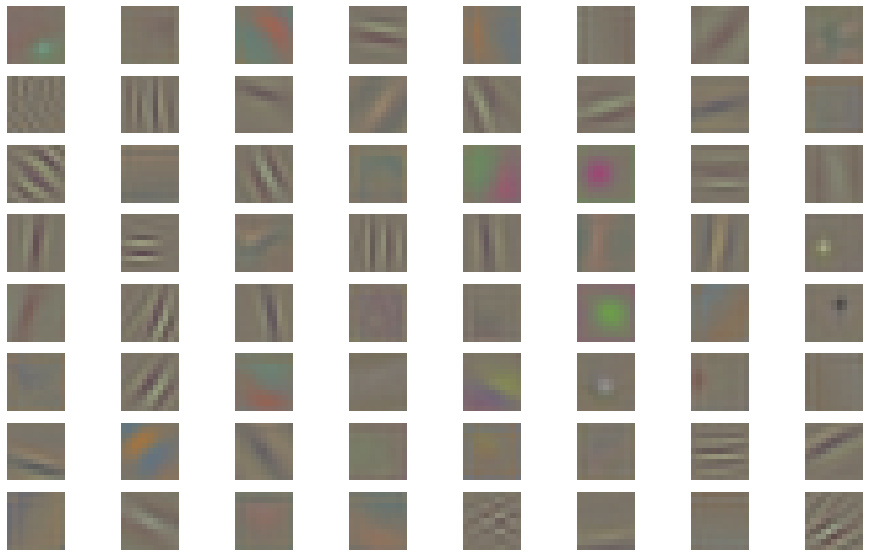

In [ ]:
#!g1.1
plt.figure(figsize=(16, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    image = list(alexnet.named_parameters())[0][1][i].detach().to('cpu').numpy() #[0,:,:]
    image[0] = image[0]*0.229 + 0.485
    image[1] = image[1]*0.224 + 0.456
    image[2] = image[2]*0.225 + 0.406
    plt.imshow(image.transpose((1, 2, 0)) )
    plt.axis('off')

### Вывод
На первом слое ResNet и AlexNet работают похоже, они детектируют горизонтальные, вертикальные линии и линии под углом, переход цветов, где-то 'шахматную доску'. При этом VGG19 выделяет более крупные паттерны. 

Размер ядер на первом сверточном слое у нейросетей разные. У ResNet - 7, y VGG19 - 3, у AlexNet - 11. Проглядывается тенденция - чем больше размер ядра, тем более мелкие паттерны распознаёт сеть на первом слое.

## Фильтры следующих слоев

У следующих слоев нейросети больше, чем 3 канала. Попробуем визуализировать некоторые фильтры и некоторые каналы на первых и последних слоях сетей.

### ResNet18

conv1.weight


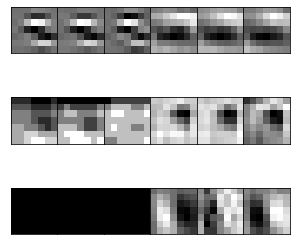

layer1.0.conv1.weight


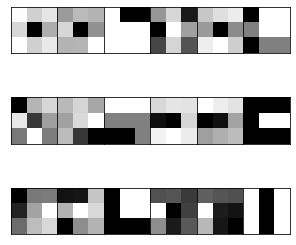

layer4.1.conv1.weight


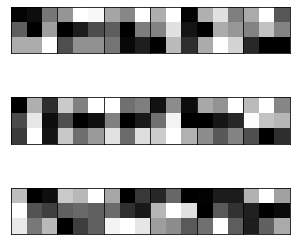

layer4.1.conv2.weight


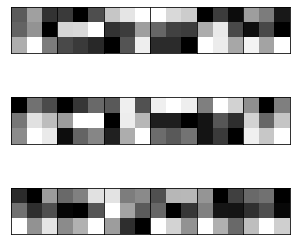

In [ ]:
k = 0
for name, param in resnet18.named_parameters():
  if re.search('conv1.weight', name) or re.search('conv2.weight', name):
    k+=1
    if k < 3 or  k > 15:
        print(name)

        weights = param.detach().to('cpu')
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        filter_cnt=1
        plt.figure(figsize=(5,5))
        plt.subplots_adjust(wspace=0, hspace=0)
        for i in range(6):
            for j in range(3):
                ax= plt.subplot(3, 6, filter_cnt )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filters[i, j, :,:], cmap='gray')
                filter_cnt+=1
        plt.show()

### VGG19

layer  1


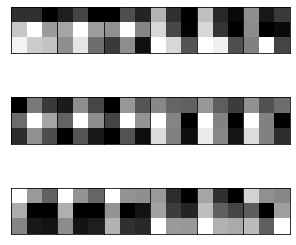

layer  2


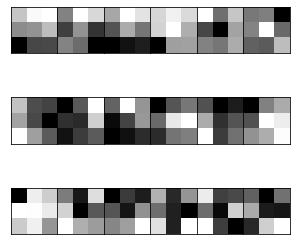

layer  15


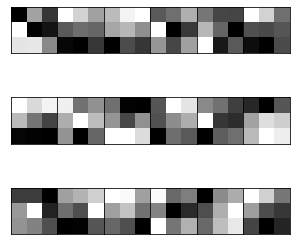

layer  16


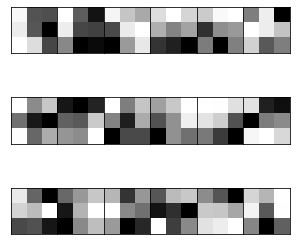

In [ ]:
k = 0
seq = list(vgg19.children())[0]
for layer in seq.children():
  # print(name)
  if type(layer) == nn.Conv2d:
    k+=1
    if k < 3 or  k > 14:
        print('layer ', k)

        weights = layer.weight.detach().to('cpu')
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        filter_cnt=1
        plt.figure(figsize=(5,5))
        plt.subplots_adjust(wspace=0, hspace=0)
        for i in range(6):
            for j in range(3):
                ax= plt.subplot(3, 6, filter_cnt )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filters[i, j, :,:], cmap='gray')
                filter_cnt+=1
        plt.show()

### AlexNet

layer  0


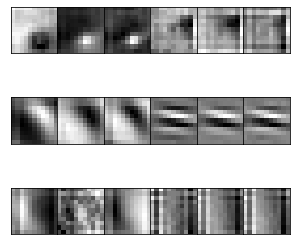

layer  1


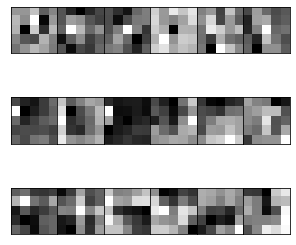

layer  2


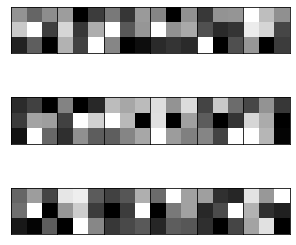

layer  3


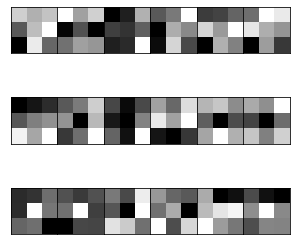

layer  4


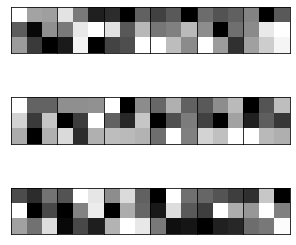

In [ ]:
k = 0
seq = list(alexnet.children())[0]
for layer in seq.children():
  # print(name)
  if type(layer) == nn.Conv2d:
      print('layer ', k)

      weights = layer.weight.detach().to('cpu')
      f_min, f_max = weights.min(), weights.max()
      filters = (weights - f_min) / (f_max - f_min)  
      filter_cnt=1
      plt.figure(figsize=(5,5))
      plt.subplots_adjust(wspace=0, hspace=0)
      for i in range(6):
          for j in range(3):
              ax= plt.subplot(3, 6, filter_cnt )
              ax.set_xticks([])
              ax.set_yticks([])
              plt.imshow(filters[i, j, :,:], cmap='gray')
              filter_cnt+=1
      plt.show()
      k+=1

Фильтры маленького размера дают немного информации. В фильтрах большего размера можно разглядеть текстуру (линии), и какие-то части подсвеченные части(например, у AlexNet в первом слое). Также в ResNet18 есть полностью черные фильтры - это мертвые нейроны

### Активация на различных слоях

В процесее прямого прохода запомним то, что выдает каждый сверточный слой на выходе. Это тоже будут многоканальные изображения, будем визуализировать несколько каналов на каждом слое.

(-0.5, 223.5, 223.5, -0.5)

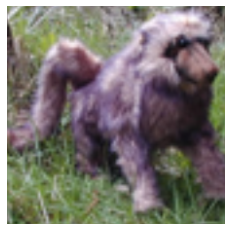

In [ ]:
x = val_loader.dataset.__getitem__(1000)[0]

x_batch = x.unsqueeze(0)

image = val_loader.dataset.__getitem__(1000)[0]
image[0] = image[0]*0.229 + 0.485
image[1] = image[1]*0.224 + 0.456
image[2] = image[2]*0.225 + 0.406
plt.imshow(image.permute((1,2,0)))
plt.axis('off')


### VGG 19

In [ ]:
seq = list(vgg19.children())[0]
res = x_batch.to(device)
outputs = []
with torch.no_grad():
  for layer in seq.children():
    res = layer(res)
    if type(layer) == nn.Conv2d:
      outputs.append(res.detach().to('cpu'))


layer 0


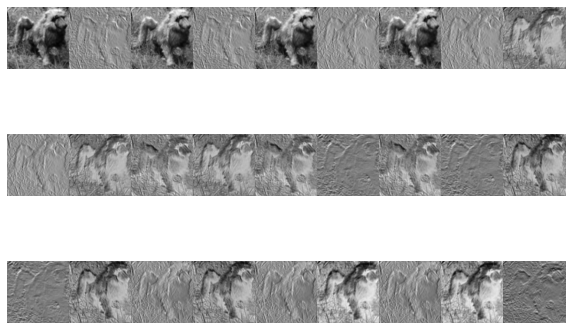

layer 1


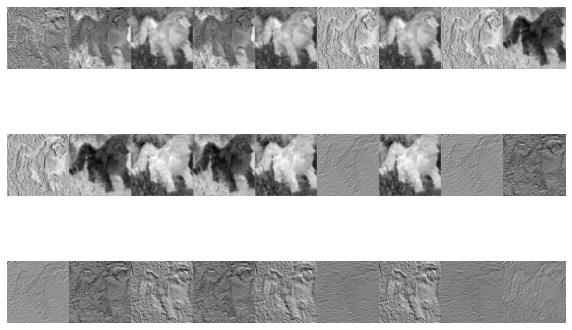

layer 2


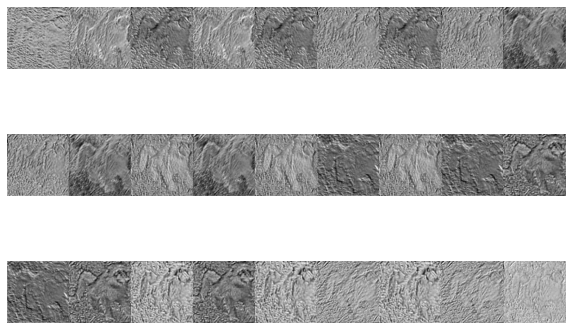

layer 3


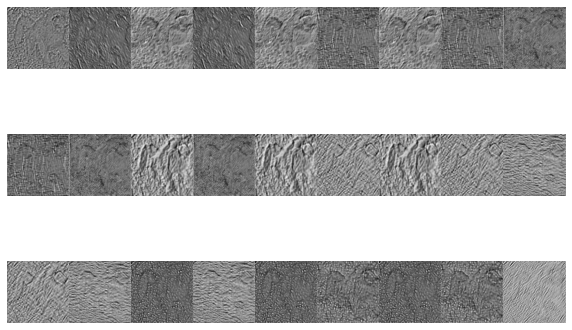

layer 4


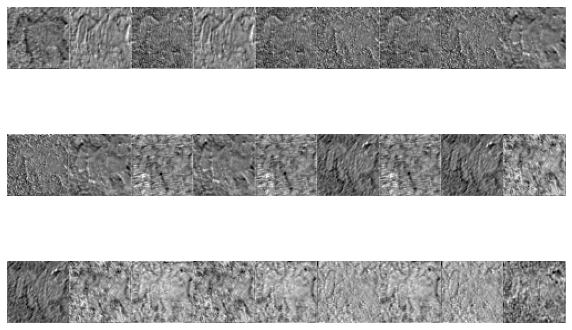

layer 5


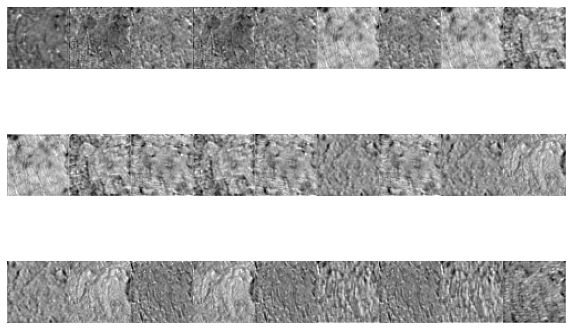

layer 6


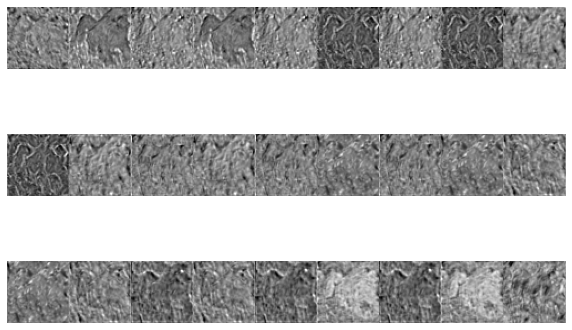

layer 7


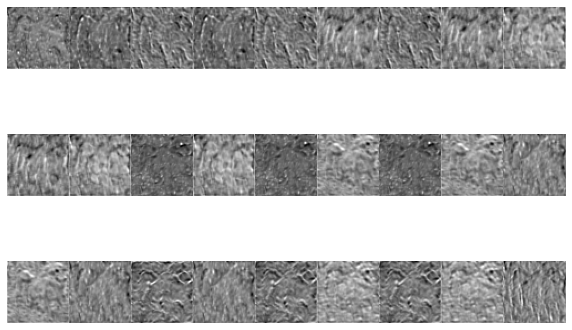

layer 8


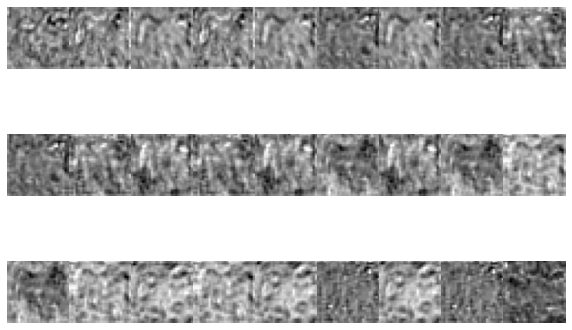

layer 9


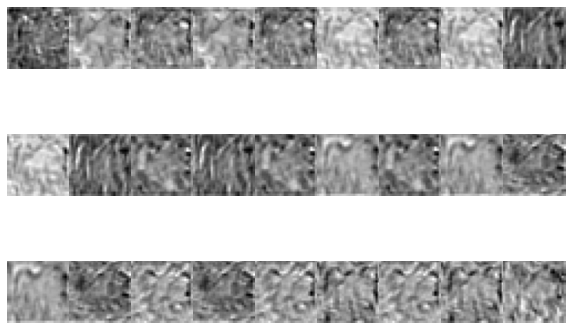

layer 10


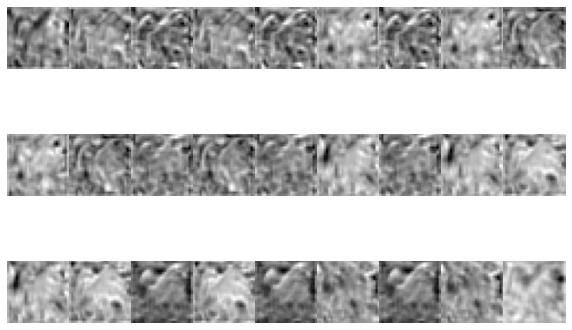

layer 11


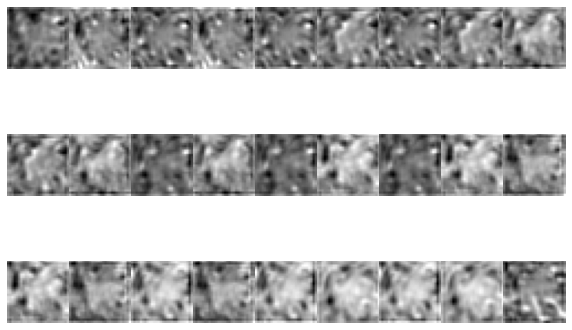

layer 12


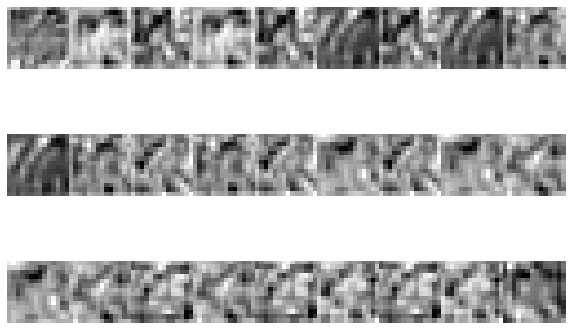

layer 13


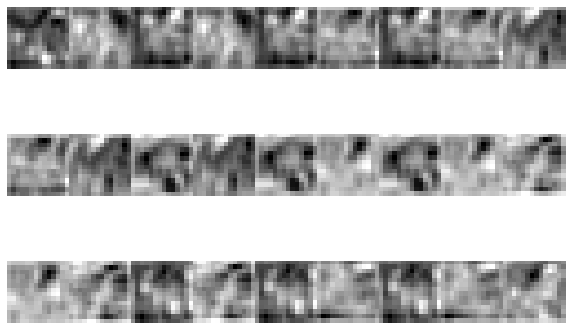

layer 14


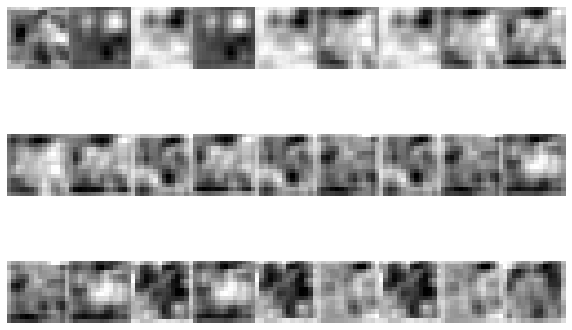

layer 15


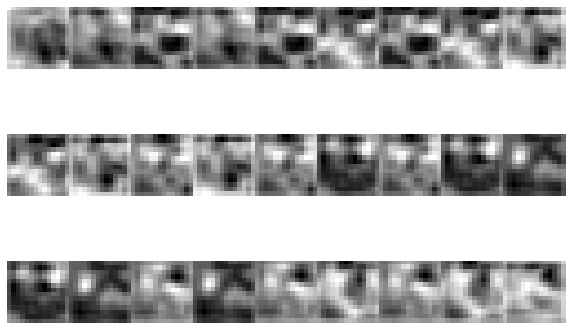

In [ ]:
m = 0
for img in outputs:
  print('layer', m)
  image = img[0]
  k = 1

  plt.figure(figsize=(10,7))
  plt.subplots_adjust(wspace=0, hspace=0)
  for i in range(9):
    for j in range(3):
      plt.subplot(3, 9, k)
      plt.imshow(image[j + i], cmap='gray')
      plt.axis('off')
      k += 1
  plt.show()
  m += 1

### AlexNet

In [ ]:
seq = list(alexnet.children())[0]
res = x_batch.to(device)
outputs = []
with torch.no_grad():
  for layer in seq.children():
    res = layer(res)
    if type(layer) == nn.Conv2d:
      outputs.append(res.detach().to('cpu'))

layer 0


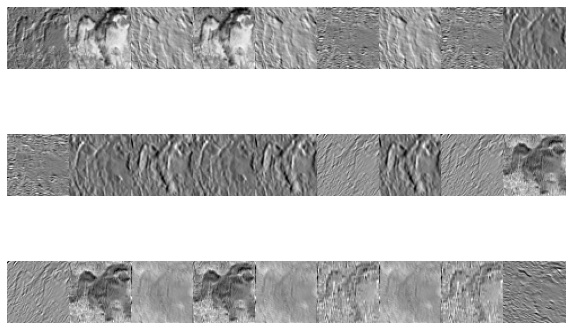

layer 1


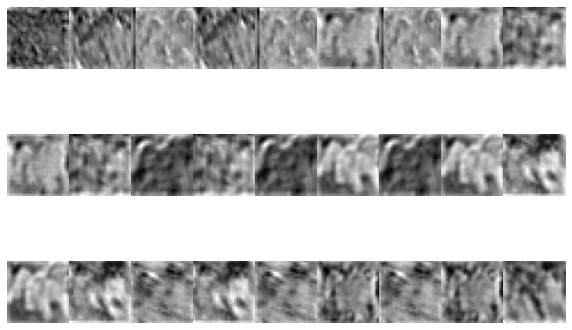

layer 2


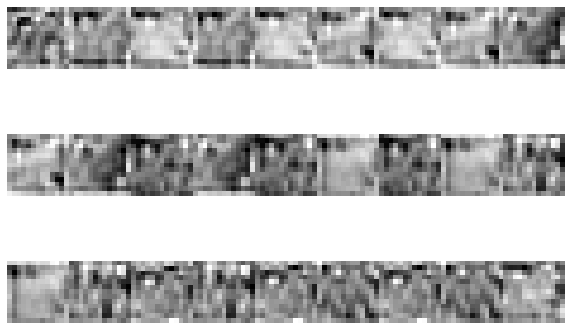

layer 3


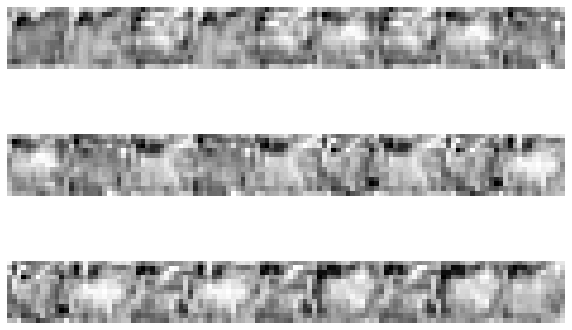

layer 4


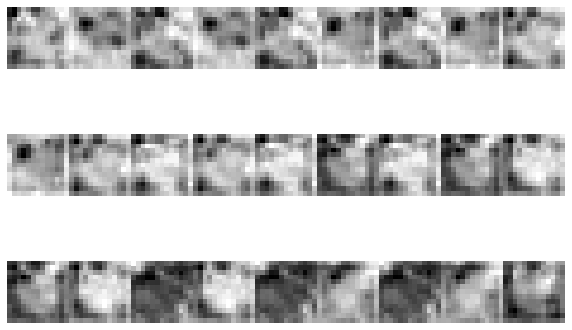

In [ ]:
m = 0
for img in outputs:
  print('layer', m)
  image = img[0]
  k = 1

  plt.figure(figsize=(10,7))
  plt.subplots_adjust(wspace=0, hspace=0)
  for i in range(9):
    for j in range(3):
      plt.subplot(3, 9, k)
      plt.imshow(image[j + i], cmap='gray')
      plt.axis('off')
      k += 1
  plt.show()
  m += 1

На первых слоях нейроны обращают внимание на всю картинку в целом, выделяют какие-то определенные линии, формы объектов. На каждом следующем слое, картинка активации становится все более и более размытой.На последнях слоя подсвечиваются конкретные области картинки.

## Визуализация пространства перед последним подносвязным слоем. Ближашие соседи.

Рассмотрим нейросети в качестве эмбеддинга, то есть в качестве модели, которая выдаёт нам пространство, в котором представлены наши исходные сложные объекты. 

Каждое изображение прогоним через всю сеть, исключая последние слои, которые осуществляют классификацию. Получим вектор в некотором пространстве. Попробуем для некоторых изображений найти 5 ближайших соседей и посмотреть насколько данное пространство действительно близкие объекты считает близкими.

### ResNet

In [ ]:
X_resnet = []
y_resnet = []


In [ ]:
#!g1.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

In [ ]:
#!g1.1
layers = list(resnet18.children())
for i in range(len(val_loader)):
    image, label = val_loader.dataset.__getitem__(i)
    y_resnet.append(label)

    x_batch = image.unsqueeze(0)
    res = x_batch.to(device)
    with torch.no_grad():
        for i in range(len(layers)-1):
            res = layers[i](res)
        X_resnet.append(res[0].cpu().detach().numpy())

In [ ]:
X_resnet = np.array(X_resnet)
y_resnet = np.array(y_resnet)

In [ ]:
X_resnet = X_resnet.reshape((X_resnet.shape[0], X_resnet.shape[1]))

In [ ]:
X_resnet.shape, y_resnet.shape

((2000, 512), (2000,))

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_resnet)

NearestNeighbors()

In [ ]:
ind = neigh.kneighbors(X_resnet[:10], return_distance=False)

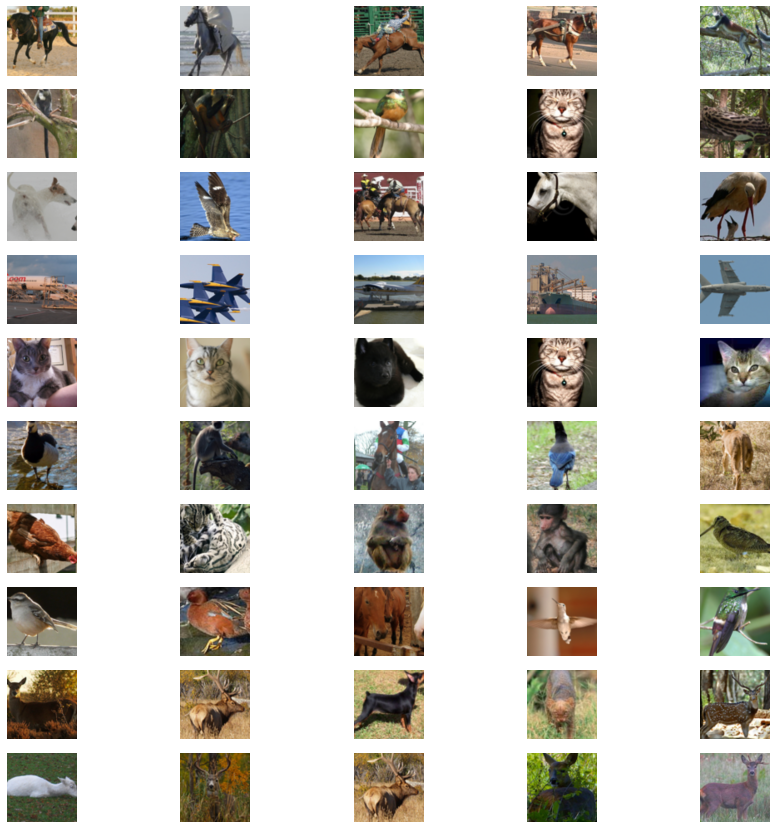

In [ ]:
k = 1
j = 10
plt.figure(figsize=(15,15))
for m in range(j):
  for i in ind[m]:
      image = val_loader.dataset.__getitem__(i)[0]
      plt.subplot(j,5,k)
      image[0] = image[0]*0.229 + 0.485
      image[1] = image[1]*0.224 + 0.456
      image[2] = image[2]*0.225 + 0.406
      plt.imshow(image.permute((1,2,0)))
      plt.axis('off')
      k+=1

Нельзя сказать, что близкие объекты находятся близко к друг другу. Например, для курицы ближайшим соседом оказалась кошка и обезьяны. Для собаки ближайшими соседями оказались птицы и лошади. Однако для первой картинки лошади 3 ближайшими соседями тоже оказались лошади. Для кошки он определили ближайшими соседями тоже кошек за исключанием одной картинки, лицо собаки на которой сеть путает скорее всего с кошкой. Также можно заметить, что сеть путает животных с животными, а не собак с самолетами.

### VGG 19

In [ ]:
X_vgg = []
y_vgg = []

In [ ]:
#!g1.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg19 = vgg19.to(device)

In [ ]:
#!g1.1
layers = list(vgg19.children())
for i in range(len(val_loader)):
    image, label = val_loader.dataset.__getitem__(i)
    y_vgg.append(label)

    x_batch = image.unsqueeze(0)
    res = x_batch.to(device)
    with torch.no_grad():
        for i in range(len(layers)-1):
            res = layers[i](res)
        X_vgg.append(res[0].cpu().detach().numpy())

In [ ]:
X_vgg = np.array(X_vgg)
y_vgg = np.array(y_vgg)

In [ ]:
X_vgg.shape, y_vgg.shape

((2000, 512, 7, 7), (2000,))

In [ ]:
X_vgg = X_vgg.reshape((X_vgg.shape[0], -1))

In [ ]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_vgg)

NearestNeighbors()

In [ ]:
ind = neigh.kneighbors(X_vgg[:10], return_distance=False)

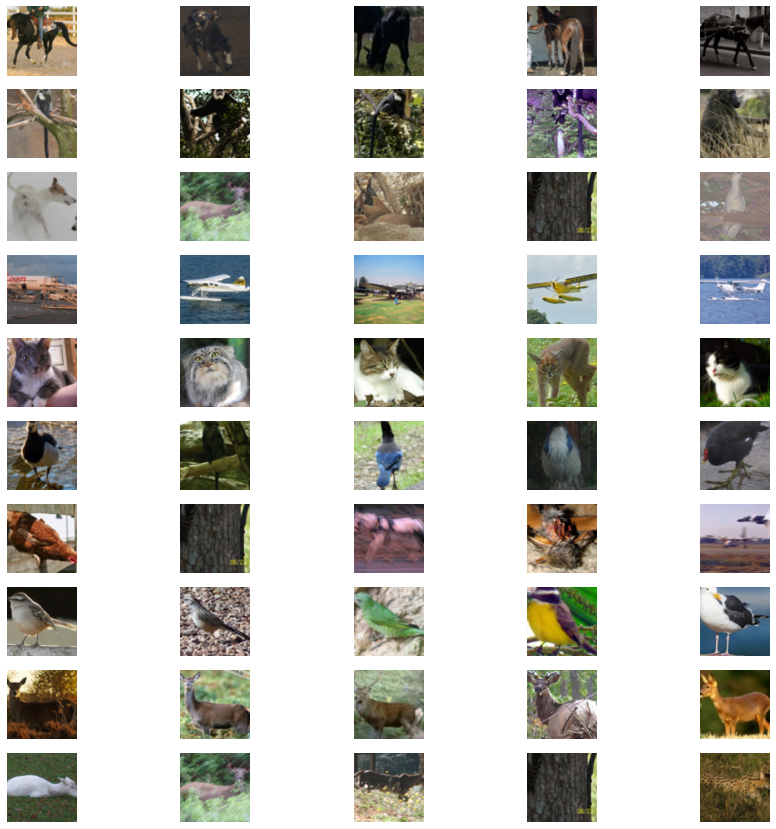

In [ ]:
k = 1
j = 10
plt.figure(figsize=(15,15))
for m in range(j):
  for i in ind[m]:
      image = val_loader.dataset.__getitem__(i)[0]
      plt.subplot(j,5,k)
      image[0] = image[0]*0.229 + 0.485
      image[1] = image[1]*0.224 + 0.456
      image[2] = image[2]*0.225 + 0.406
      plt.imshow(image.permute((1,2,0)))
      plt.axis('off')
      k+=1

Здесь ближайшие соседи определились более удачно, чем в ResNet. Оленям соотвествуют олени, лошадкам - лошади, кошкам- кошки. Однако сеть плохо справляется с размытыми картинками.

### AlexNet

In [ ]:
X_alex = []
y_alex = []

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

In [ ]:
#!g1.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
layers = list(alexnet.children())
for i in range(len(val_loader)):
    image, label = val_loader.dataset.__getitem__(i)
    y_alex.append(label)

    x_batch = image.unsqueeze(0)
    res = x_batch.to(device)
    with torch.no_grad():
        for i in range(len(layers)-1):
            res = layers[i](res)
        X_alex.append(res[0].cpu().detach().numpy())

In [ ]:
X_alex = np.array(X_alex)
y_alex = np.array(y_alex)


In [ ]:
X_alex.shape, y_alex.shape

((2000, 256, 6, 6), (2000,))

In [ ]:
X_alex = X_alex.reshape((X_alex.shape[0], -1))

In [ ]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_alex)

NearestNeighbors()

In [ ]:
ind = neigh.kneighbors(X_alex[:10], return_distance=False)

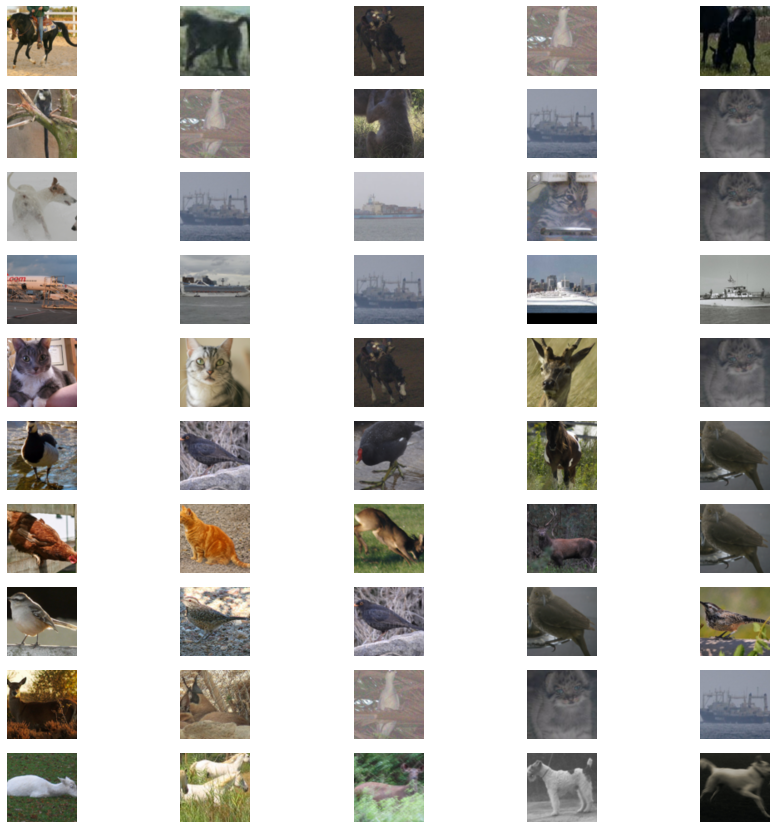

In [ ]:
k = 1
j = 10
plt.figure(figsize=(15,15))
for m in range(j):
  for i in ind[m]:
      image = val_loader.dataset.__getitem__(i)[0]
      plt.subplot(j,5,k)
      image[0] = image[0]*0.229 + 0.485
      image[1] = image[1]*0.224 + 0.456
      image[2] = image[2]*0.225 + 0.406
      plt.imshow(image.permute((1,2,0)))
      plt.axis('off')
      k+=1

Здесь пространство ведет себя довольно странно. Например, собаке на второй картинке в качестве ближайших соседей попались корабли и кошки. Птицам ещё более или менее соотвествуют птицы, но на остальных картинках сеть работает не очень хорошо.

## Визуализация пространства перед последним подносвязным слоем. TSNE

Теперь попробуем визуализировать данное пространство. Уже на основе ближайших соседей можно сделать некоторый вывод о пространствах. Например, пространство в VGG19 скорее всего будет разбито на некоторые кластеры, в то время как в других сетях, этого не будет.

Переведем наше пространство в двумерное с помощью TSNE и посмотрим как расположены классы в пространстве. Визуализируем сначал с помошью точек, а потом с помощью картинок.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

In [ ]:
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    _, image_height, image_width = image.shape
    center_x = int(image_centers_area_size * x) + offset
    center_y = int(image_centers_area_size * (1 - y)) + offset
    tl_x = center_x - int(image_height/ 2)
    tl_y = center_y - int(image_width / 2)
    br_x = tl_x + image_height
    br_y = tl_y + image_width
    return tl_x, tl_y, br_x, br_y


### ResNet

In [ ]:
tsne = TSNE(n_components=2)
X_embedded_res = tsne.fit_transform(X_resnet)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tx = X_embedded_res[:, 0]
ty = X_embedded_res[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


In [ ]:
X_resnet.shape, y_resnet.shape

((2000, 512), (2000,))

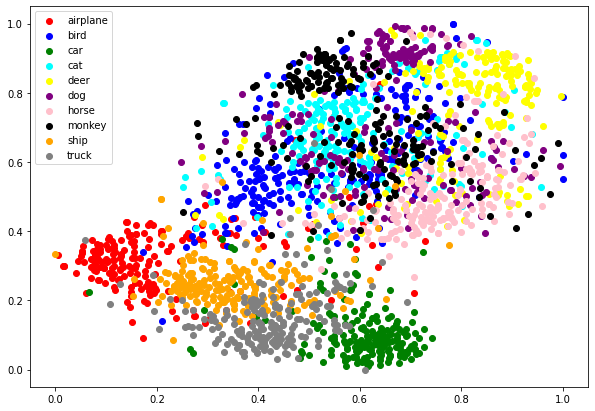

In [ ]:
plt.figure(figsize=(10,7))
labels = np.array(dataset.classes)
color = np.array(['red', 'blue', 'green', 'cyan', 'yellow', 'purple', 'pink', 'black', 'orange', 'gray'])
for i in range(10):
  ind = np.where(y_resnet ==i)
  plt.scatter(tx[ind], ty[ind], color=color[i], label=labels[i])
plt.legend(loc='best')
plt.show()

На данном графике прослеживаются кластеры, однако они сильно пересекаются, поэтому сеть выдавала не совсем удачных соседей. Также мы видим, что визуально кластеры самолетов (красный), корблей(оранжевый), грузовиков(серый) и машин(зеленый) отделимы от кластеров животных и внутри между собой они различимы.

Этого нельзя сказать про животных. Немного отдельно расположился кластер оленей(желтый) и лошадей(розовый). Остальные кластеры сильно смешены.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


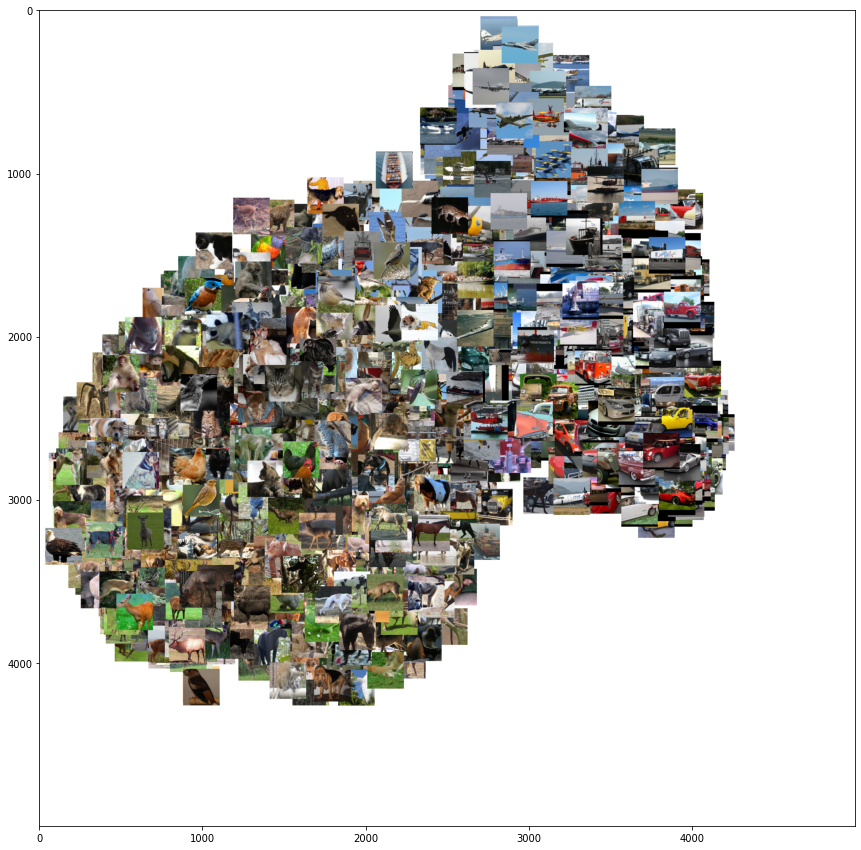

In [ ]:
plot_size=8000
tsne_plot = 255 * torch.ones((3, plot_size, plot_size))
k = 0
for image_label, x, y in zip(val_loader.dataset, tx, ty):
    image = image_label[0]
    image[0] = image[0]*0.229 + 0.485
    image[1] = image[1]*0.224 + 0.456
    image[2] = image[2]*0.225 + 0.406
    label = y_resnet[k]
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size=4000, offset = 150)
    tsne_plot[:, tl_x:br_x, tl_y:br_y] = image
    k += 1

plt.figure(figsize=(15, 15))
plt.imshow(tsne_plot.permute((1,2,0))[:5000, :5000, :])
plt.show()


Здесь мы видим тоже самое, что и на предыдущей картинке. Но тут заметно, почему например, самолеты далеко расположены от машин. Нейросеть также смотри на цвета изображения и там, где изображены самолеты много голубого цвета. Также много голубого цвета на картинках, где есть корабли. Поэтому эти кластеры пересекаются и близко расположены. А у животных преобладает зеленый цвет.

### VGG19

In [ ]:
tsne = TSNE(n_components=2)
X_embedded_vgg = tsne.fit_transform(X_vgg)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tx = X_embedded_vgg[:, 0]
ty = X_embedded_vgg[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


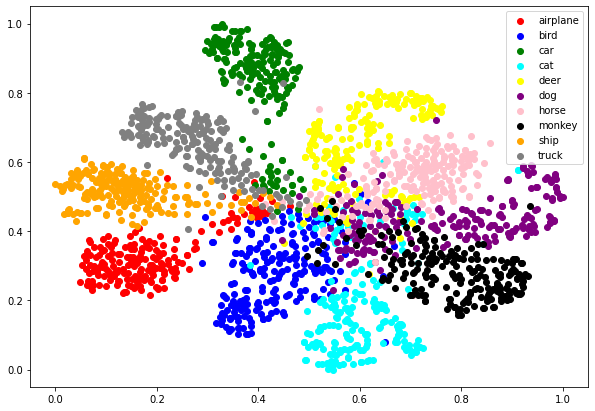

In [ ]:
plt.figure(figsize=(10,7))
labels = np.array(dataset.classes)
color = np.array(['red', 'blue', 'green', 'cyan', 'yellow', 'purple', 'pink', 'black', 'orange', 'gray'])
for i in range(10):
    ind = np.where(y_vgg ==i)
    plt.scatter(tx[ind], ty[ind], color=color[i], label=labels[i])
plt.legend(loc='best')
plt.show()

Классы хорошо отделимы, есть пересечение всех классов по центру. Классы, относящиеся к животным, близки друг к другу. Тоже самое можно сказать про стредства передвижения (машины, самолеты, грузовики)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


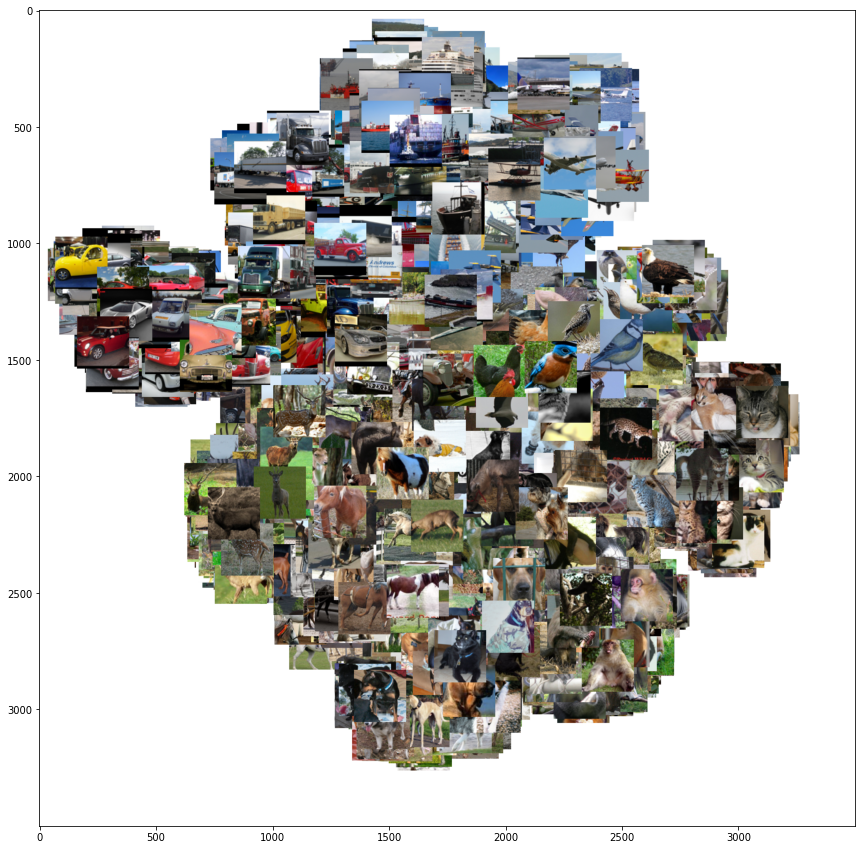

In [ ]:
plot_size=6000
tsne_plot = 255 * torch.ones((3, plot_size, plot_size))
k = 0
for image_label, x, y in zip(val_loader.dataset, tx, ty):
    image = image_label[0]
    image[0] = image[0]*0.229 + 0.485
    image[1] = image[1]*0.224 + 0.456
    image[2] = image[2]*0.225 + 0.406
    label = y_vgg[k]
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size=3000, offset = 150)
    tsne_plot[:, tl_x:br_x, tl_y:br_y] = image
    k += 1

plt.figure(figsize=(15, 15))
plt.imshow(tsne_plot.permute((1,2,0))[:3500, :3500, :])
plt.show()

### AlexNet

In [ ]:
tsne = TSNE(n_components=2)
X_embedded_alex = tsne.fit_transform(X_alex)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tx = X_embedded_alex[:, 0]
ty = X_embedded_alex[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

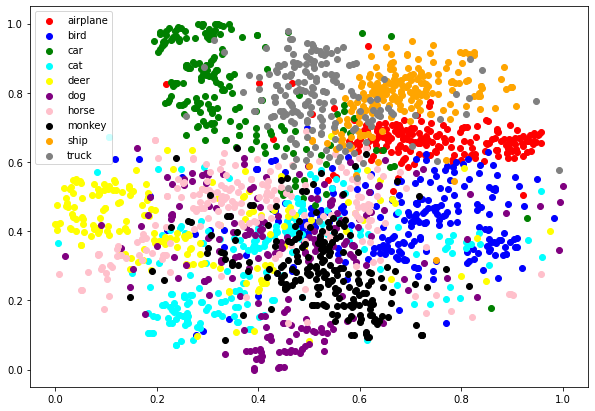

In [ ]:
plt.figure(figsize=(10,7))
labels = np.array(dataset.classes)
color = np.array(['red', 'blue', 'green', 'cyan', 'yellow', 'purple', 'pink', 'black', 'orange', 'gray'])
for i in range(10):
    ind = np.where(y_alex ==i)
    plt.scatter(tx[ind], ty[ind], color=color[i], label=labels[i])
plt.legend(loc='best')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


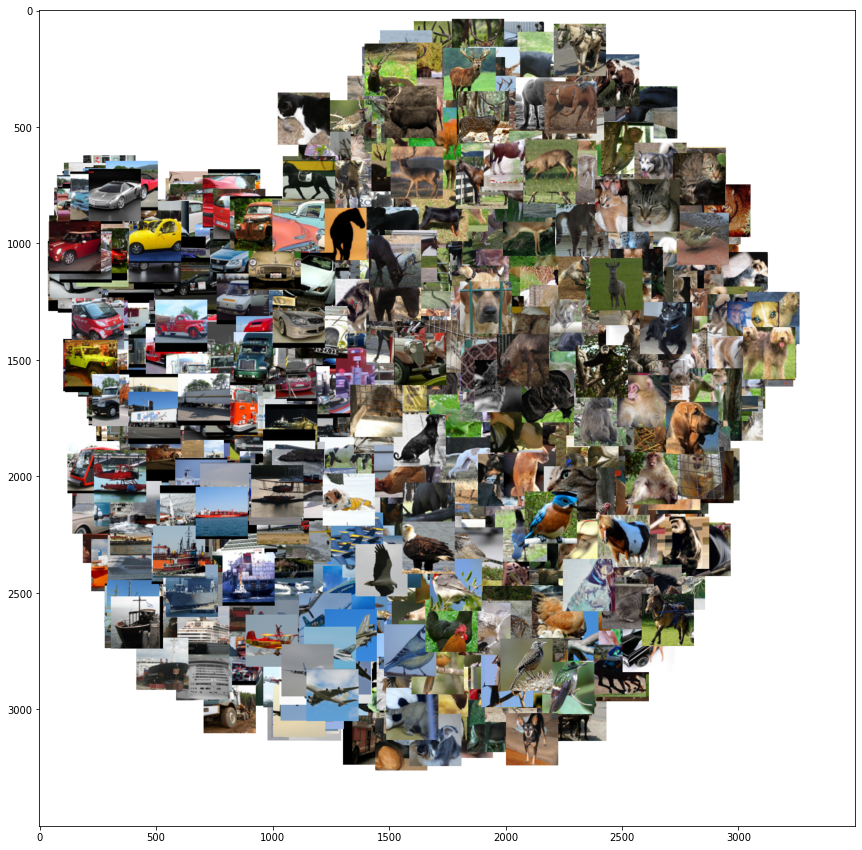

In [ ]:
plot_size=6000
tsne_plot = 255 * torch.ones((3, plot_size, plot_size))
k = 0
for image_label, x, y in zip(val_loader.dataset, tx, ty):
    image = image_label[0]
    image[0] = image[0]*0.229 + 0.485
    image[1] = image[1]*0.224 + 0.456
    image[2] = image[2]*0.225 + 0.406
    label = y_alex[k]
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size=3000, offset = 150)
    tsne_plot[:, tl_x:br_x, tl_y:br_y] = image
    k += 1

plt.figure(figsize=(15, 15))
plt.imshow(tsne_plot.permute((1,2,0))[:3500, :3500, :])
plt.show()

Тут классы плохо отделимы. Еще можно как-то отделить машины, самолеты, грузовики и корабли. Животные между собой слабо различимы. Картинка кластеров выглядит более перемешенной, чем в ResNet. Однако также заметно, что сеть обращает внимание на цвета. Картинки, где много синего расположены рядом друг с другом. Тоже самое можно сказать о картинках, где много зеленого цвета.

## Вывод:

Исходя из данного анализа, наиболее подходящее пространство было получено из сети VGG19. Данную сеть можно использовать в качестве векторного представления картинок на данном наборе данных. В данном пространстве классы хорошо отделимы.

Другие две сети показали не очень хороший результат. В них сложно выделить кластеры, классы пересекаются. Классы животных между собой очень близки.